## Import package

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import warnings
warnings.filterwarnings("ignore")

2024-07-22 01:13:05.531101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 01:13:05.531214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 01:13:05.670251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Handling dataset

In [2]:
image_size = 224
batch_size = 16
dir_data = "/kaggle/input/brain-tumor-mri-dataset"

In [3]:
train_paths = []
train_labels = []

test_paths = []
test_labels = []

filepath = os.listdir(dir_data)
for path in filepath:
    if path == 'Training':
        list_labels = os.listdir(os.path.join(dir_data, path))
        for label in list_labels:
            label_path = os.path.join(dir_data, path, label)
            files_list = os.listdir(label_path)
            for file in files_list:
                files = os.path.join(label_path, file)
                train_paths.append(files)
                train_labels.append(label)  # Use label instead of path
    else:
        list_labels = os.listdir(os.path.join(dir_data, path))
        for label in list_labels:
            label_path = os.path.join(dir_data, path, label)
            files_list = os.listdir(label_path)
            for file in files_list:
                files = os.path.join(label_path, file)
                test_paths.append(files)
                test_labels.append(label)  # Use label instead of path


In [4]:
train_series = pd.Series(train_paths, name='file path')
label_train_series = pd.Series(train_labels, name='label')
train_df = pd.concat([train_series, label_train_series], axis=1)
train_df.head()

file path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

In [5]:
test_series = pd.Series(test_paths, name='file path')
label_test_series = pd.Series(test_labels, name='label')
test_df = pd.concat([test_series, label_test_series], axis=1)
test_df.head()

file path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

In [6]:
valid_df, df_test = train_test_split(test_df, test_size = 0.5, shuffle=True, random_state=42)

In [7]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               horizontal_flip=True,
                               brightness_range=(1.1,1.3))
test_gen = ImageDataGenerator()
train_generator = train_gen.flow_from_dataframe(train_df,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=True,
                                 batch_size=batch_size)
test_generator = test_gen.flow_from_dataframe(df_test,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=False,
                                 batch_size=batch_size)
valid_generator = test_gen.flow_from_dataframe(valid_df,
                                 x_col='file path',
                                 y_col='label',
                                 target_size = (image_size,image_size),
                                 class_mode='categorical',
                                 color_mode='rgb',
                                 shuffle=True,
                                 batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [9]:
def augmented_images(generator, num_batches):
    total_images = 0
    for i in range(num_batches):
        images, labels = next(generator)
        total_images += len(images)
        fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
        for img, ax in zip(images, axes):
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
        plt.show()
    return total_images

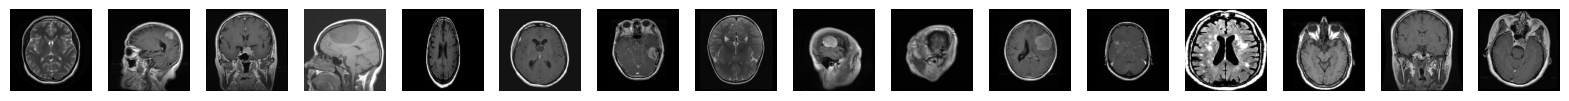

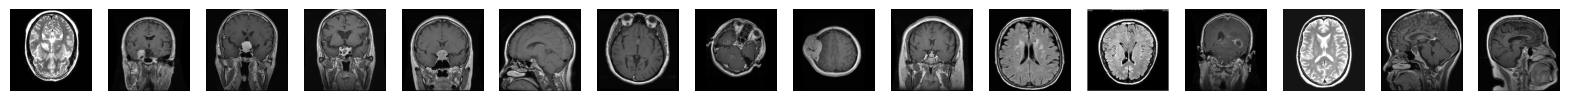

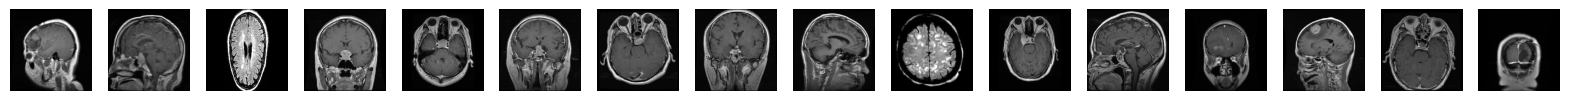

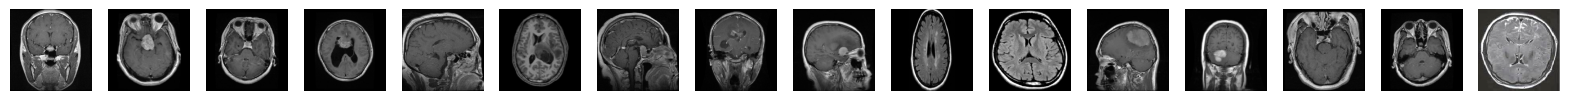

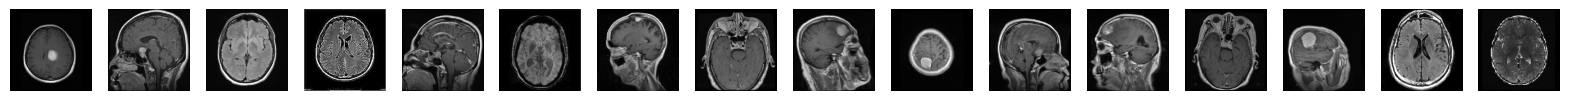

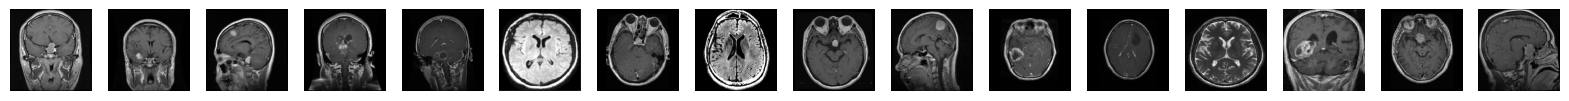

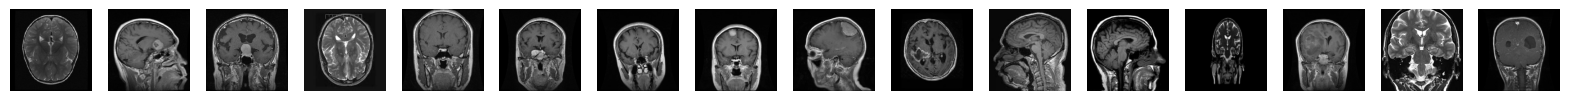

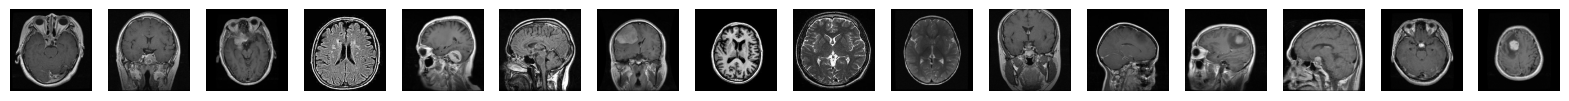

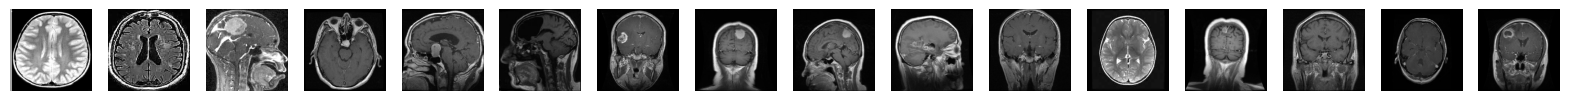

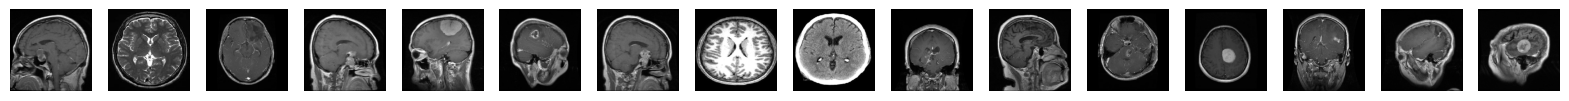

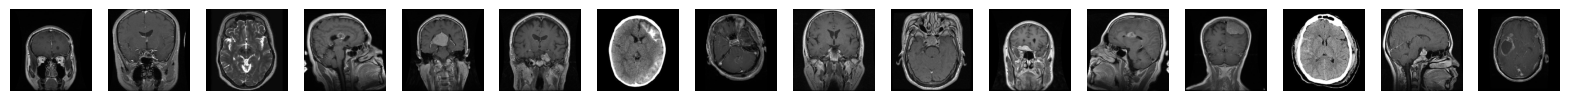

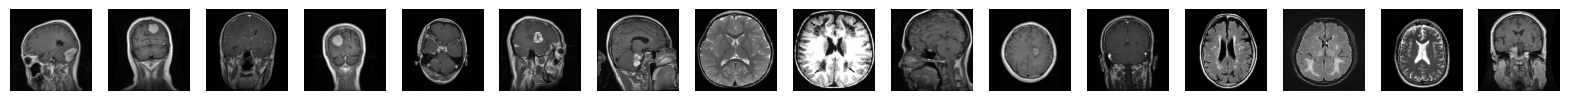

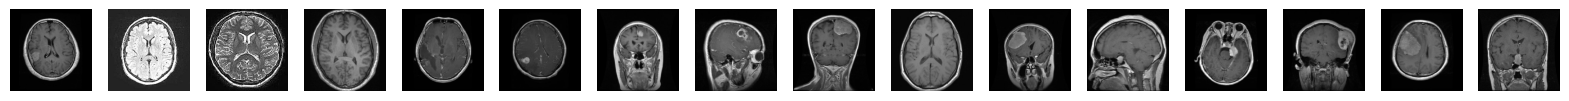

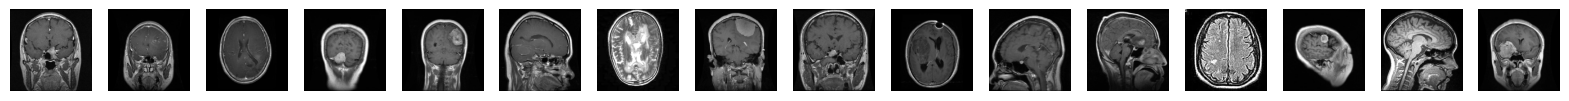

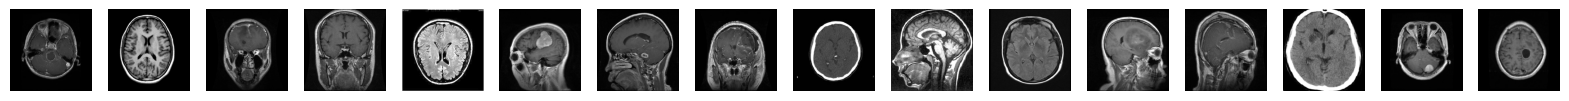

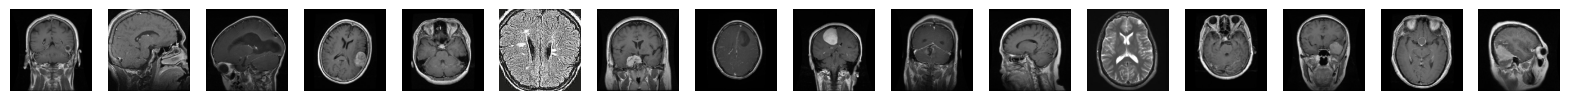

In [10]:
train_images = augmented_images(train_generator, batch_size)

In [12]:
print(f"Total gambar yang di-augmentasi dalam {batch_size} batch: {train_images}")

Total gambar yang di-augmentasi dalam 16 batch: 256


## Modelling

In [8]:
convnextbase = ConvNeXtBase(include_top=False,
                             weights="imagenet",
                             input_shape=(image_size,image_size,3),
                             pooling='max')

for layer in convnextbase.layers[:-10]:
    layer.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
def model_convnextbase(optimizer, learning_rate, dropout, momentum=0.9):
    model = Sequential([
    convnextbase,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(512, kernel_regularizer = regularizers.l1_l2(l1=0.0005, l2=0.001),
                activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(4, activation='softmax')
    ])
    
    if optimizer == tf.keras.optimizers.SGD:
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer_instance = optimizer(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [10]:
def history_model(model, train_data, epoch, verbose, valid_data, shuffle):
    history = model.fit(train_data, epochs=epoch, 
                        verbose=verbose, validation_data=valid_data,
                       shuffle=shuffle)
    return history

In [11]:
import seaborn as sns
def plot_history(history):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss values plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def evaluate_model(model, train, valid, test, verbose):
    train_score = model.evaluate(train, verbose=verbose)
    validation_score = model.evaluate(valid, verbose=verbose)
    test_score = model.evaluate(test, verbose=verbose)

In [13]:
def predict_model(model, test):
    preds = model.predict(test)
    y_pred = np.argmax(preds, axis=1)
    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())
    cm = confusion_matrix(test.classes, y_pred)
    return y_pred, classes, cm

In [14]:
def plot_cm(cm, classes):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, 
                yticklabels=classes, cbar=True, square=True)
    plt.title('Confusion Matrix')
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [15]:
def report_model(test, predict_test, classes):
    report = classification_report(test.classes, predict_test, target_names=classes)
    return print(report)

## Optimizer Adam

### Konfigurasi model 
- Learning rate = 0.001
- Dropout = 0.25

In [19]:
model_adam_1 = model_convnextbase(Adam, 0.001, 0.25)

In [20]:
history_adam_1 = history_model(model_adam_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:04:21 31s/step - accuracy: 0.2500 - loss: 10.8689

I0000 00:00:1721553581.252518     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721553581.302329     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553581.302705     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553581.303101     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553581.310079     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553581.310417     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553581.310925     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8150 - loss: 7.4529

W0000 00:00:1721553628.264239     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553628.264703     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553628.265062     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553628.272223     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553628.272606     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553628.273013     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 87s 157ms/step - accuracy: 0.8151 - loss: 7.4471 - val_accuracy: 0.9389 - val_loss: 2.1216
Epoch 2/30


W0000 00:00:1721553637.313718     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553637.314149     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553637.314589     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553637.321713     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553637.322095     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721553637.322553     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9594 - loss: 1.3704 - val_accuracy: 0.9344 - val_loss: 0.7730
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9656 - loss: 0.5339 - val_accuracy: 0.9634 - val_loss: 0.4918
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9562 - loss: 0.5262 - val_accuracy: 0.9450 - val_loss: 0.4606
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9772 - loss: 0.3356 - val_accuracy: 0.9664 - val_loss: 0.3813
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9854 - loss: 0.2594 - val_accuracy: 0.9847 - val_loss: 0.3269
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9827 - loss: 0.2942 - val_accuracy: 0.9832 - val_loss: 0.2612
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9885 - loss: 0.2133 - val_accuracy: 0.9756 - val_loss: 0.2551
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9915 - loss: 0.1965 - val

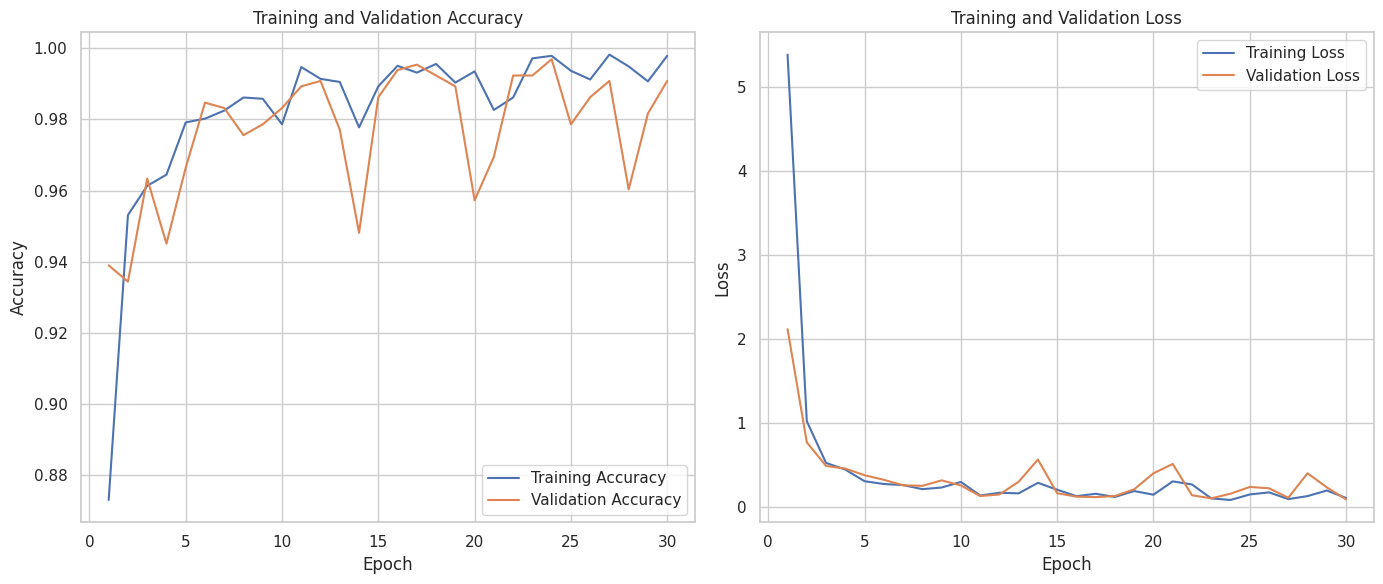

In [21]:
plot_history(history_adam_1)

In [24]:
evaluate_model(model_adam_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9999 - loss: 0.0604
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9921 - loss: 0.0777
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9921 - loss: 0.0831


In [25]:
y_pred_adam_1, classes, cm_adam_1 = predict_model(model_adam_1, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step

W0000 00:00:1721555207.921377     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555207.921842     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555207.922258     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555207.929276     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555207.929665     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555207.930043     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step


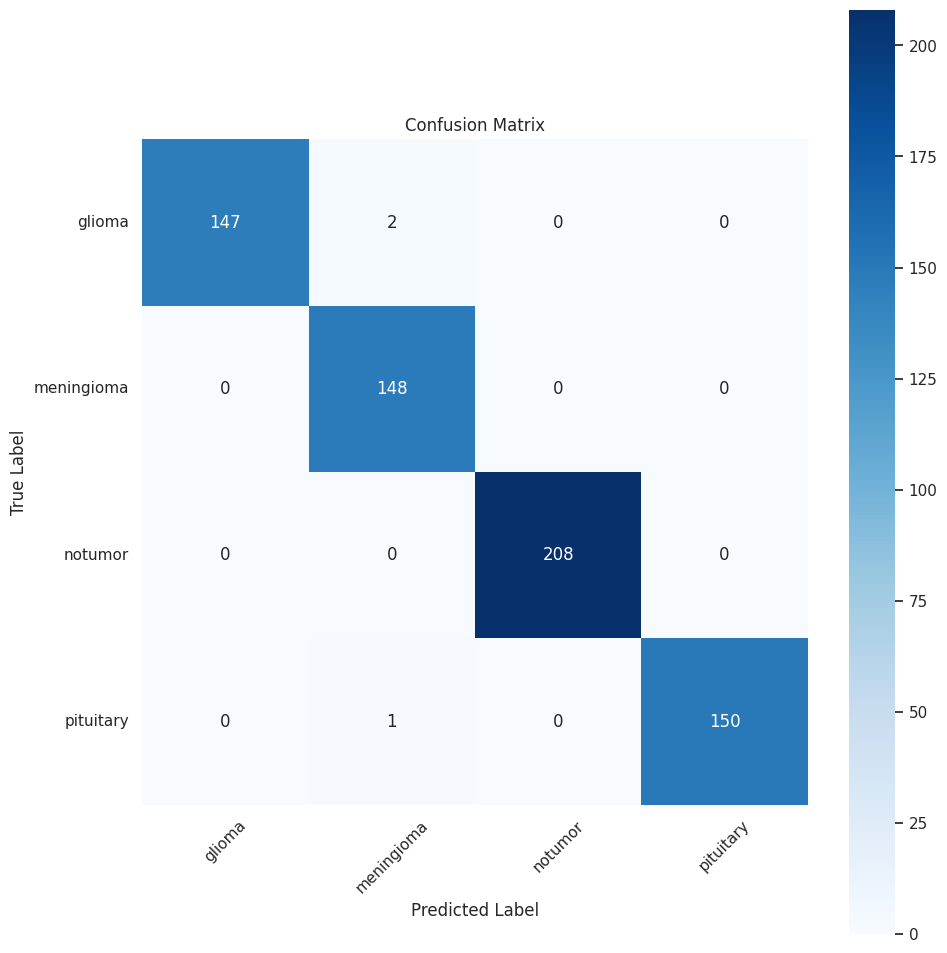

In [26]:
plot_cm(cm_adam_1, classes)

In [27]:
report_model(test_generator, y_pred_adam_1, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       149
  meningioma       0.98      1.00      0.99       148
     notumor       1.00      1.00      1.00       208
   pituitary       1.00      0.99      1.00       151

    accuracy                           1.00       656
   macro avg       1.00      0.99      0.99       656
weighted avg       1.00      1.00      1.00       656



In [29]:
model_adam_1.save('classification_brain_tumor_convnextbase_adam.h5')

### Konfigurasi model 
- learning rate = 0.001
- dropout = 0.45

In [18]:
model_adam_2 = model_convnextbase(Adam,0.001, 0.45)

In [19]:
history_adam_2 = history_model(model_adam_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:04:45 31s/step - accuracy: 0.1875 - loss: 10.7123

I0000 00:00:1721555607.941363     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721555607.990878     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555607.991209     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555607.991634     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555607.999333     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7987 - loss: 7.8656

W0000 00:00:1721555653.328545     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555653.328999     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555653.329401     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 153ms/step - accuracy: 0.7989 - loss: 7.8604 - val_accuracy: 0.9282 - val_loss: 2.8366
Epoch 2/30


W0000 00:00:1721555662.305447     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555662.306021     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555662.306442     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555662.315914     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555662.316334     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721555662.316806     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9441 - loss: 2.0111 - val_accuracy: 0.9420 - val_loss: 0.7610
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9696 - loss: 0.5936 - val_accuracy: 0.9588 - val_loss: 0.5723
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9676 - loss: 0.5688 - val_accuracy: 0.9695 - val_loss: 0.4887
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9601 - loss: 0.5671 - val_accuracy: 0.8962 - val_loss: 0.9238
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9724 - loss: 0.4930 - val_accuracy: 0.9771 - val_loss: 0.3231
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9873 - loss: 0.2837 - val_accuracy: 0.9695 - val_loss: 0.4188
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9795 - loss: 0.3675 - val_accuracy: 0.9802 - val_loss: 0.3799
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9845 - loss: 0.3521 - val

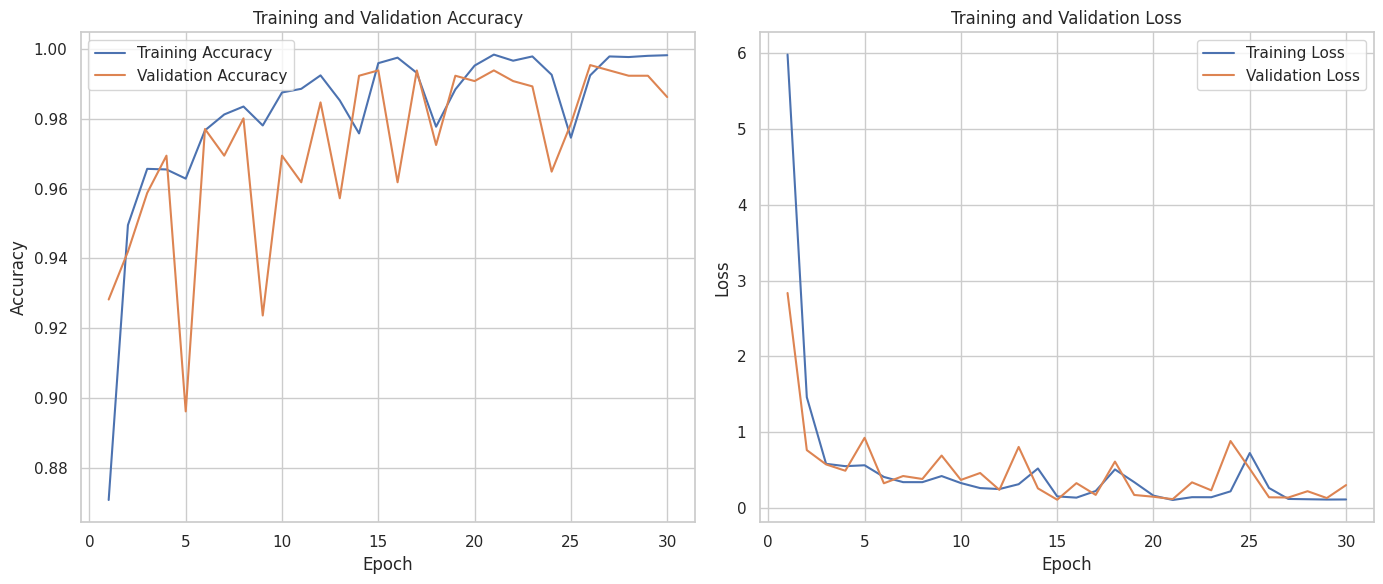

In [20]:
plot_history(history_adam_2)

In [21]:
evaluate_model(model_adam_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9937 - loss: 0.2072
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9846 - loss: 0.3584
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9727 - loss: 0.3401


In [22]:
y_pred_adam_2, classes, cm_adam_2 = predict_model(model_adam_2, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

W0000 00:00:1721557047.182463     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557047.182921     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557047.183380     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


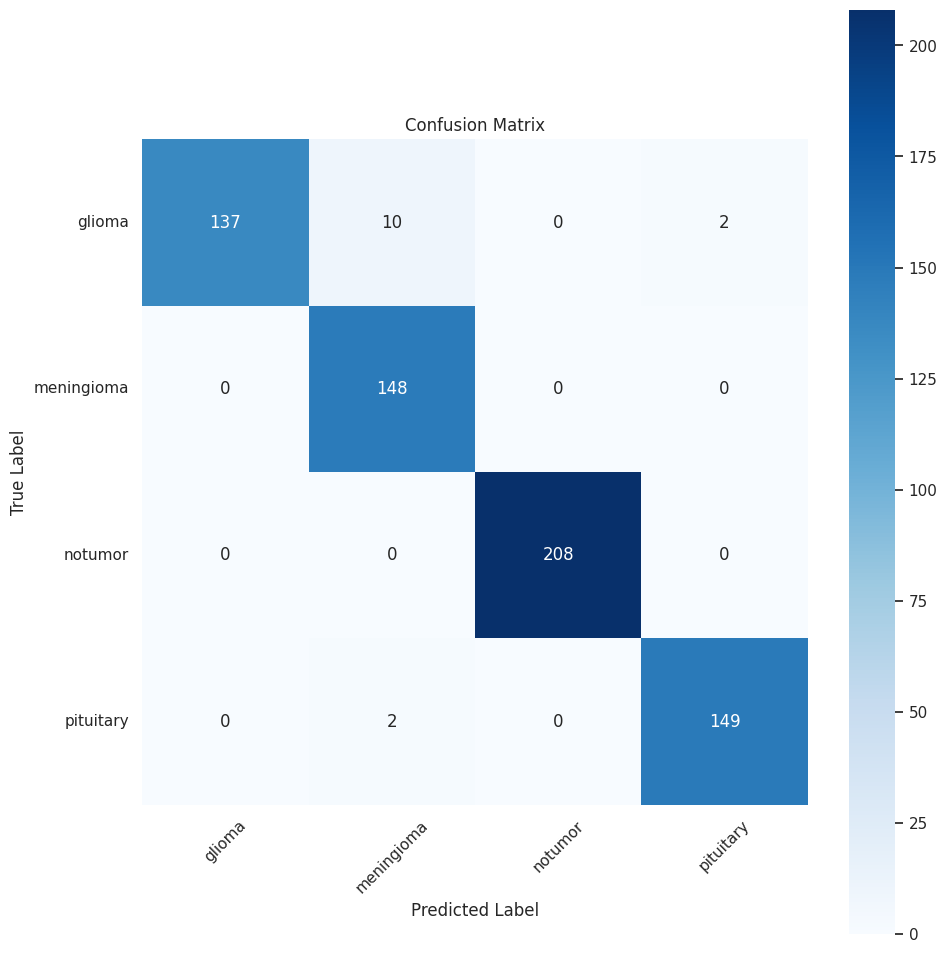

In [23]:
plot_cm(cm_adam_2, classes)

In [24]:
report_model(test_generator, y_pred_adam_2, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96       149
  meningioma       0.93      1.00      0.96       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [25]:
model_adam_2.save('classification_brain_tumor_convnextbase_adam_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.25

In [18]:
model_adam_3 = model_convnextbase(Adam,0.0001, 0.25)

In [19]:
history_adam_3 = history_model(model_adam_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:22:15 34s/step - accuracy: 0.3750 - loss: 10.5937

I0000 00:00:1721557347.033137     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721557347.086678     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557347.087156     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557347.087604     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557347.096049     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7428 - loss: 9.3492

W0000 00:00:1721557404.175830     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557404.176281     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557404.176726     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 187ms/step - accuracy: 0.7431 - loss: 9.3479 - val_accuracy: 0.9359 - val_loss: 8.1012
Epoch 2/30


W0000 00:00:1721557413.775707     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.776231     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.776755     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.779060     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.779450     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.779854     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.780232     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721557413.780667     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9542 - loss: 7.7925 - val_accuracy: 0.9664 - val_loss: 6.8369
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.9815 - loss: 6.4945 - val_accuracy: 0.9756 - val_loss: 5.5173
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9909 - loss: 5.1649 - val_accuracy: 0.9847 - val_loss: 4.2006
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9935 - loss: 3.8749 - val_accuracy: 0.9832 - val_loss: 2.9875
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9963 - loss: 2.6946 - val_accuracy: 0.9893 - val_loss: 1.9567
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9968 - loss: 1.7278 - val_accuracy: 0.9847 - val_loss: 1.1839
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.9985 - loss: 1.0122 - val_accuracy: 0.9893 - val_loss: 0.6678
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.9948 - loss: 0.5716 - val

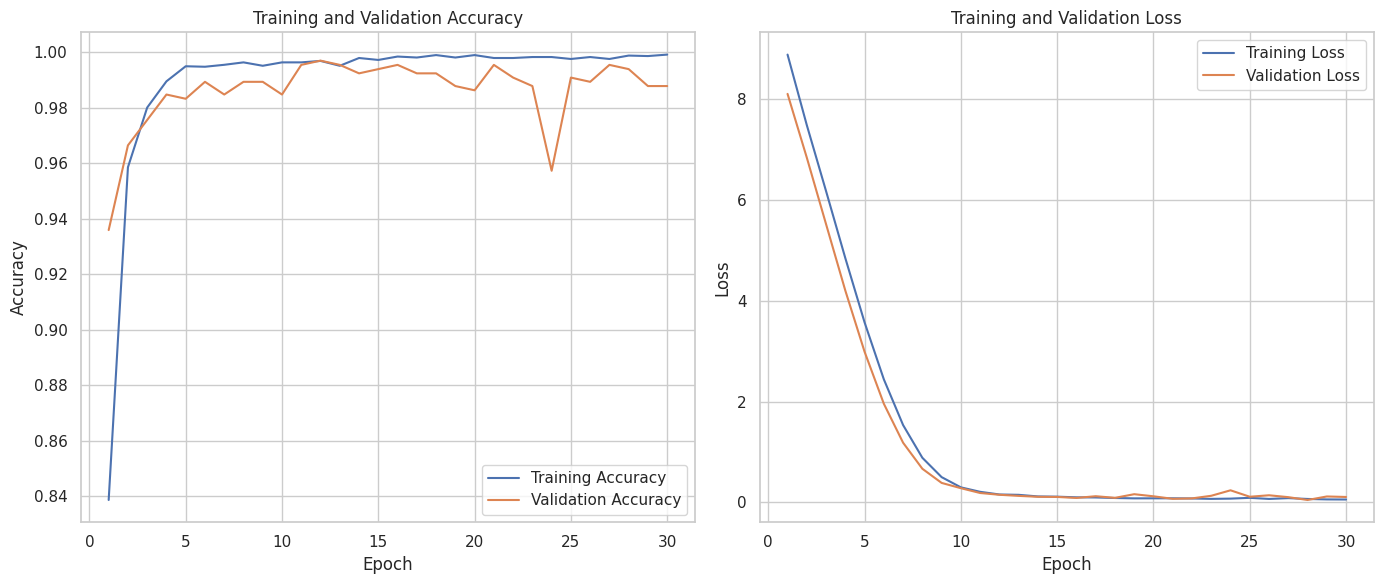

In [20]:
plot_history(history_adam_3)

In [21]:
evaluate_model(model_adam_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.9997 - loss: 0.0761
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9919 - loss: 0.0995
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9873 - loss: 0.1257


In [22]:
y_pred_adam_3, classes, cm_adam_3 = predict_model(model_adam_3, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

W0000 00:00:1721558948.643664     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721558948.643976     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721558948.644351     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step


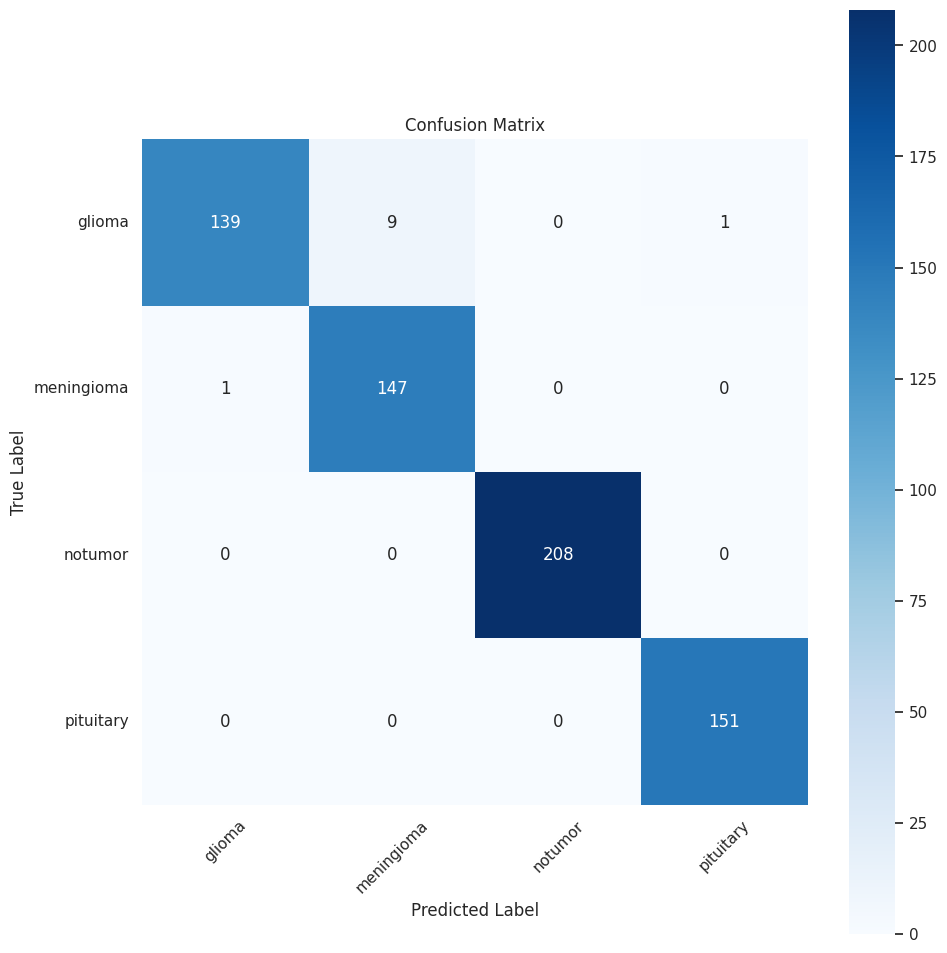

In [23]:
plot_cm(cm_adam_3, classes)

In [24]:
report_model(test_generator, y_pred_adam_3, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       149
  meningioma       0.94      0.99      0.97       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      1.00      1.00       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [25]:
model_adam_3.save('classification_brain_tumor_convnextbase_adam_3.h5')

### Konfigurasi model 
- learning rate = 0.0001
- dropout = 0.45

In [19]:
model_adam_4 = model_convnextbase(Adam, 0.0001, 0.45)

In [20]:
history_adam_4 = history_model(model_adam_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:05:03 31s/step - accuracy: 0.4375 - loss: 10.4610

I0000 00:00:1721559456.982387     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721559457.031987     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559457.032372     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559457.032742     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559457.039716     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559457.040085     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559457.040602     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7005 - loss: 9.5093

W0000 00:00:1721559508.406093     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559508.406515     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559508.406891     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559508.413888     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559508.414299     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559508.414722     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.7008 - loss: 9.5080 - val_accuracy: 0.9206 - val_loss: 8.2636
Epoch 2/30


W0000 00:00:1721559517.423350     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559517.423730     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559517.424147     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559517.430719     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559517.431082     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721559517.431498     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9347 - loss: 8.0220 - val_accuracy: 0.9649 - val_loss: 7.1673
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9682 - loss: 6.8957 - val_accuracy: 0.9786 - val_loss: 6.0322
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.9828 - loss: 5.7450 - val_accuracy: 0.9817 - val_loss: 4.8963
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9869 - loss: 4.6040 - val_accuracy: 0.9893 - val_loss: 3.7892
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9958 - loss: 3.5146 - val_accuracy: 0.9893 - val_loss: 2.7836
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9952 - loss: 2.5458 - val_accuracy: 0.9908 - val_loss: 1.9222
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9964 - loss: 1.7339 - val_accuracy: 0.9725 - val_loss: 1.2849
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9968 - loss: 1.1101 - val

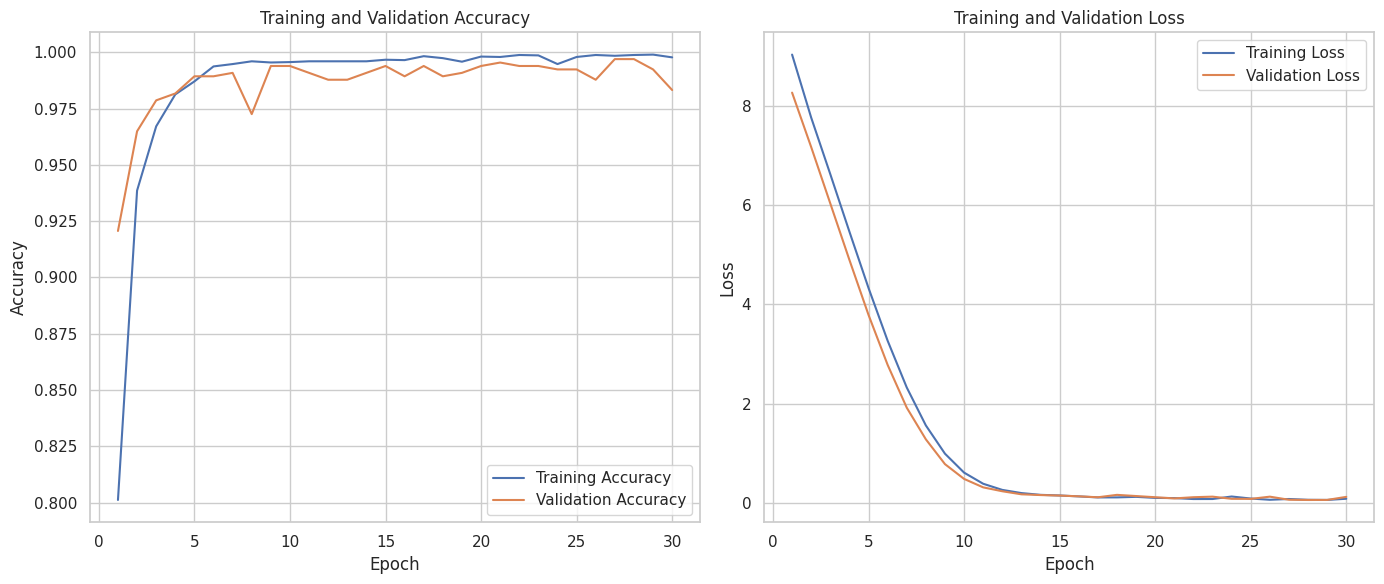

In [21]:
plot_history(history_adam_4)

In [22]:
evaluate_model(model_adam_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.9997 - loss: 0.0697
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9863 - loss: 0.1097
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9669 - loss: 0.1841


In [24]:
y_pred_adam_4, classes, cm_adam_4 = predict_model(model_adam_4, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step

W0000 00:00:1721560866.667840     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721560866.668323     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721560866.668692     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721560866.675622     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721560866.675942     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721560866.676349     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


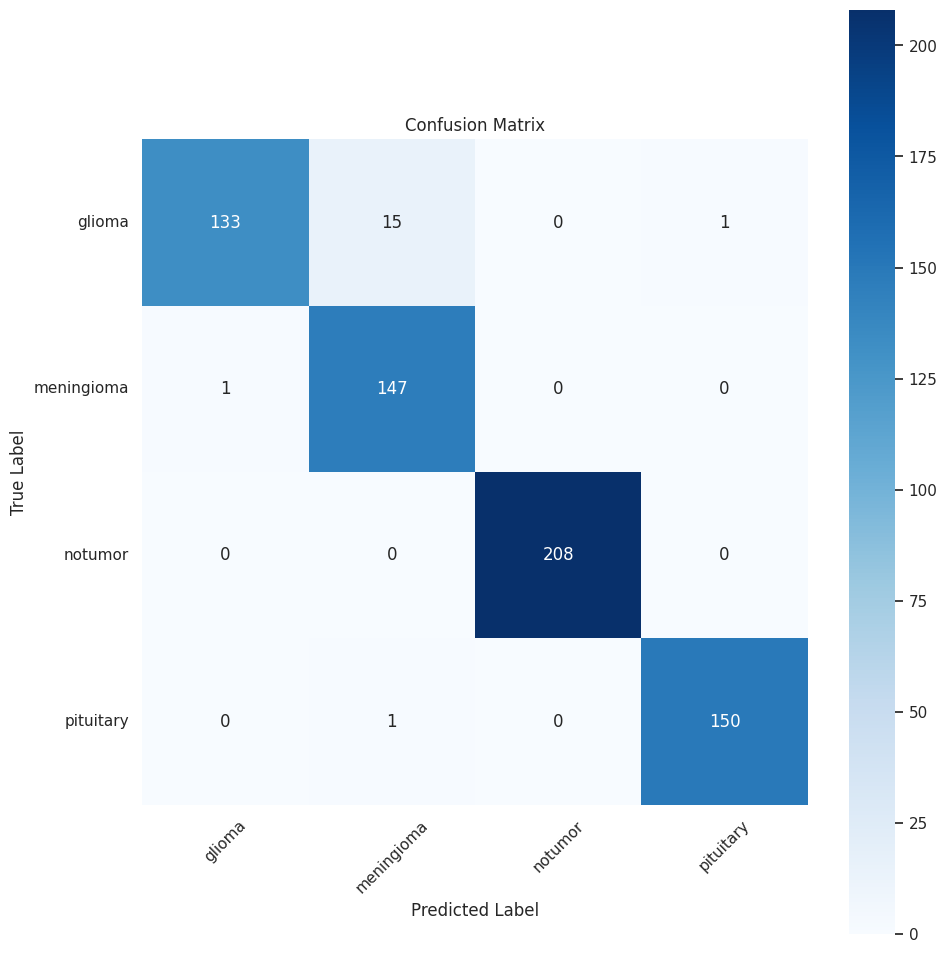

In [25]:
plot_cm(cm_adam_4, classes)

In [26]:
report_model(test_generator, y_pred_adam_4, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       149
  meningioma       0.90      0.99      0.95       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [27]:
model_adam_4.save('classification_brain_tumor_convnextbase_adam_4.h5')

## Optimizer Adamax

### Konfigurasi model
- learning rate = 0.001
- Dropout = 0.25

In [19]:
from tensorflow.keras.optimizers import Adamax

In [17]:
model_adamax_1 = model_convnextbase(Adamax,0.001, 0.25)

In [18]:
history_adamax_1 = history_model(model_adamax_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:08:51 32s/step - accuracy: 0.2500 - loss: 10.2687

I0000 00:00:1721561229.499574     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721561229.552155     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561229.552619     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561229.553057     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561229.561099     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8289 - loss: 8.5758

W0000 00:00:1721561276.698181     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561276.698532     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561276.698939     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 158ms/step - accuracy: 0.8291 - loss: 8.5733 - val_accuracy: 0.9573 - val_loss: 6.0619
Epoch 2/30


W0000 00:00:1721561285.707812     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561285.708174     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561285.708609     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561285.715203     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561285.715609     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721561285.716023     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9694 - loss: 5.3913 - val_accuracy: 0.9832 - val_loss: 3.5451
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9890 - loss: 3.0179 - val_accuracy: 0.9847 - val_loss: 1.7290
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9914 - loss: 1.4017 - val_accuracy: 0.9878 - val_loss: 0.7164
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9935 - loss: 0.5884 - val_accuracy: 0.9878 - val_loss: 0.3396
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9941 - loss: 0.3029 - val_accuracy: 0.9893 - val_loss: 0.2394
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9953 - loss: 0.2208 - val_accuracy: 0.9756 - val_loss: 0.2110
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9953 - loss: 0.1623 - val_accuracy: 0.9939 - val_loss: 0.1452
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9962 - loss: 0.1497 - val

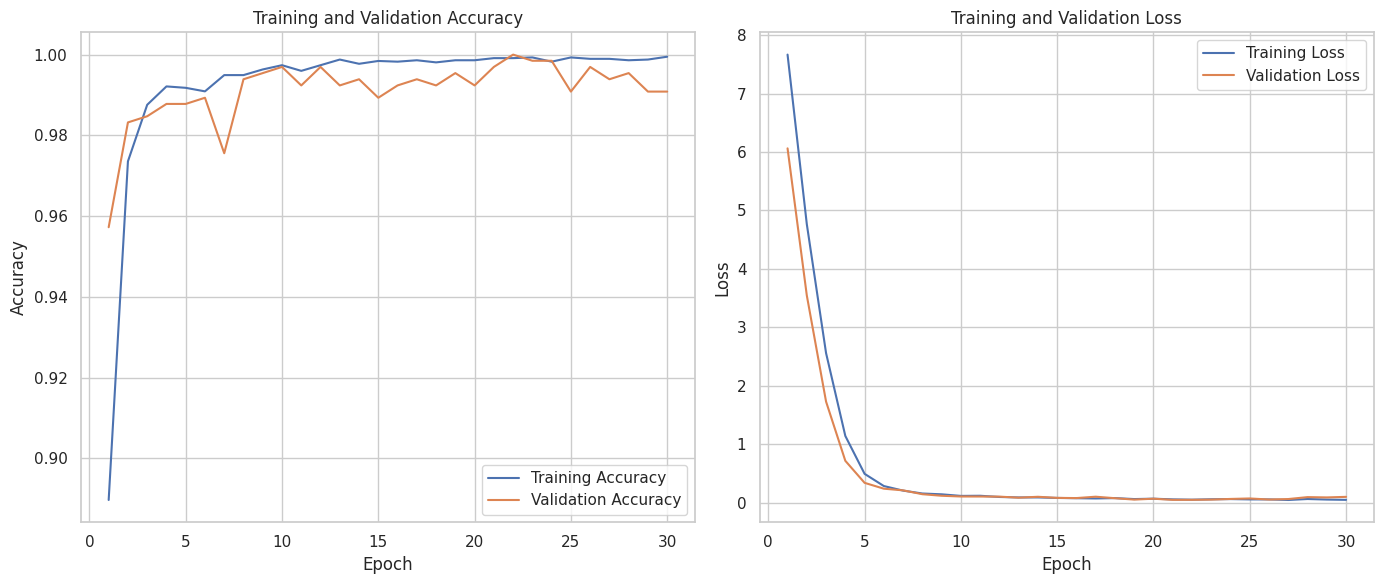

In [19]:
plot_history(history_adamax_1)

In [20]:
evaluate_model(model_adamax_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9999 - loss: 0.0798
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9929 - loss: 0.0936
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9918 - loss: 0.1064


In [21]:
y_pred_adamax_1, classes, cm_adamax_1 = predict_model(model_adamax_1, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step

W0000 00:00:1721562621.532238     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721562621.532676     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721562621.533114     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step


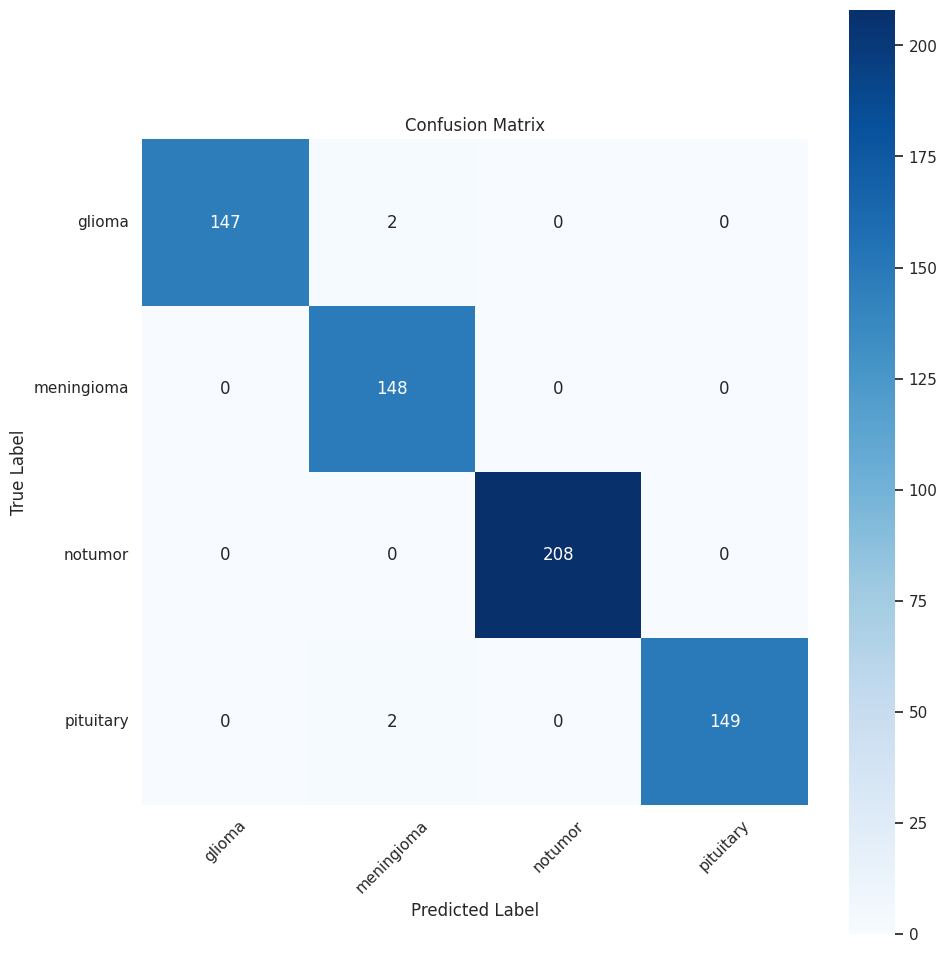

In [22]:
plot_cm(cm_adamax_1, classes)

In [23]:
report_model(test_generator, y_pred_adamax_1, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       149
  meningioma       0.97      1.00      0.99       148
     notumor       1.00      1.00      1.00       208
   pituitary       1.00      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [24]:
model_adamax_1.save('classification_brain_tumor_convnextbase_adamax_1.h5')

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.45

In [19]:
model_adamax_2 = model_convnextbase(Adamax,0.001, 0.45)

In [20]:
history_adamax_2 = history_model(model_adamax_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:01:10 31s/step - accuracy: 0.1875 - loss: 11.6548

I0000 00:00:1721563383.703953     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721563383.755598     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563383.756055     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563383.756492     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563383.764261     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8034 - loss: 8.8129

W0000 00:00:1721563443.435007     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563443.435374     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563443.435809     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 100s 195ms/step - accuracy: 0.8036 - loss: 8.8107 - val_accuracy: 0.9588 - val_loss: 6.6857
Epoch 2/30


W0000 00:00:1721563453.138714     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563453.139024     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563453.139416     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563453.146177     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563453.146524     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721563453.146912     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9584 - loss: 6.1262 - val_accuracy: 0.9710 - val_loss: 4.5857
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9809 - loss: 4.0985 - val_accuracy: 0.9802 - val_loss: 2.8216
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9858 - loss: 2.4455 - val_accuracy: 0.9740 - val_loss: 1.5346
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9918 - loss: 1.2865 - val_accuracy: 0.9771 - val_loss: 0.8035
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9937 - loss: 0.6632 - val_accuracy: 0.9771 - val_loss: 0.4344
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9914 - loss: 0.3922 - val_accuracy: 0.9893 - val_loss: 0.2882
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9938 - loss: 0.2565 - val_accuracy: 0.9908 - val_loss: 0.2229
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9972 - loss: 0.1889 - val

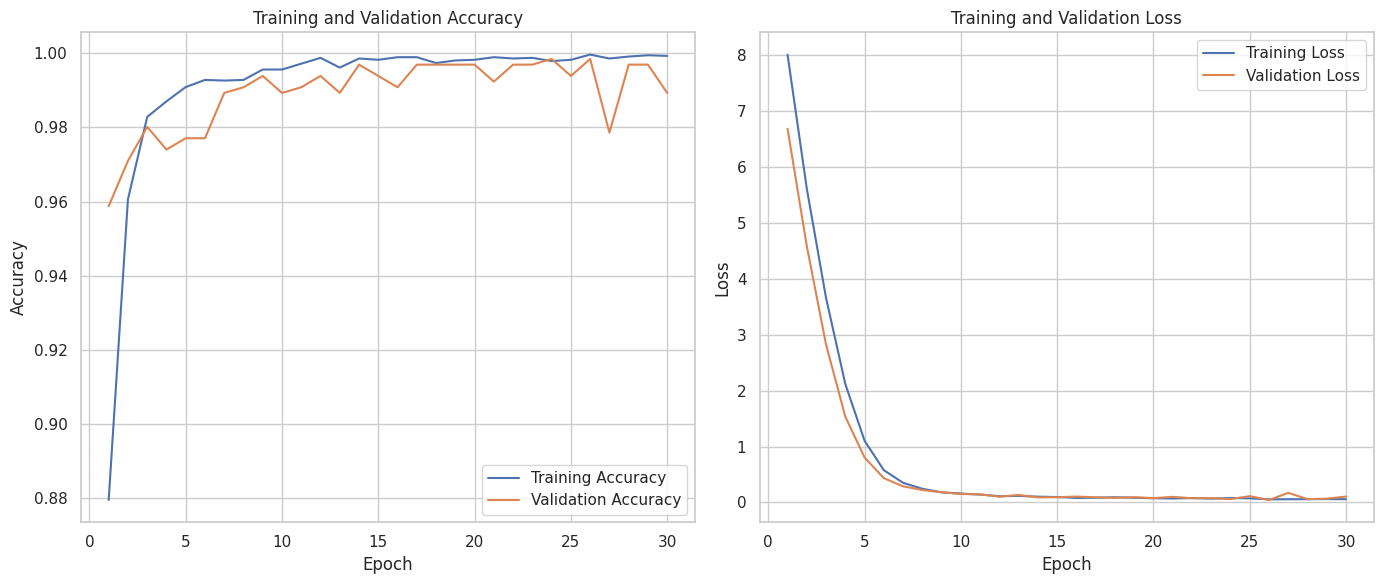

In [21]:
plot_history(history_adamax_2)

In [22]:
evaluate_model(model_adamax_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.9998 - loss: 0.0648
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9869 - loss: 0.1146
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9695 - loss: 0.1446


In [23]:
y_pred_adamax_2, classes, cm_adamax_2 = predict_model(model_adamax_2, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

W0000 00:00:1721564989.448478     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721564989.448901     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721564989.449260     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


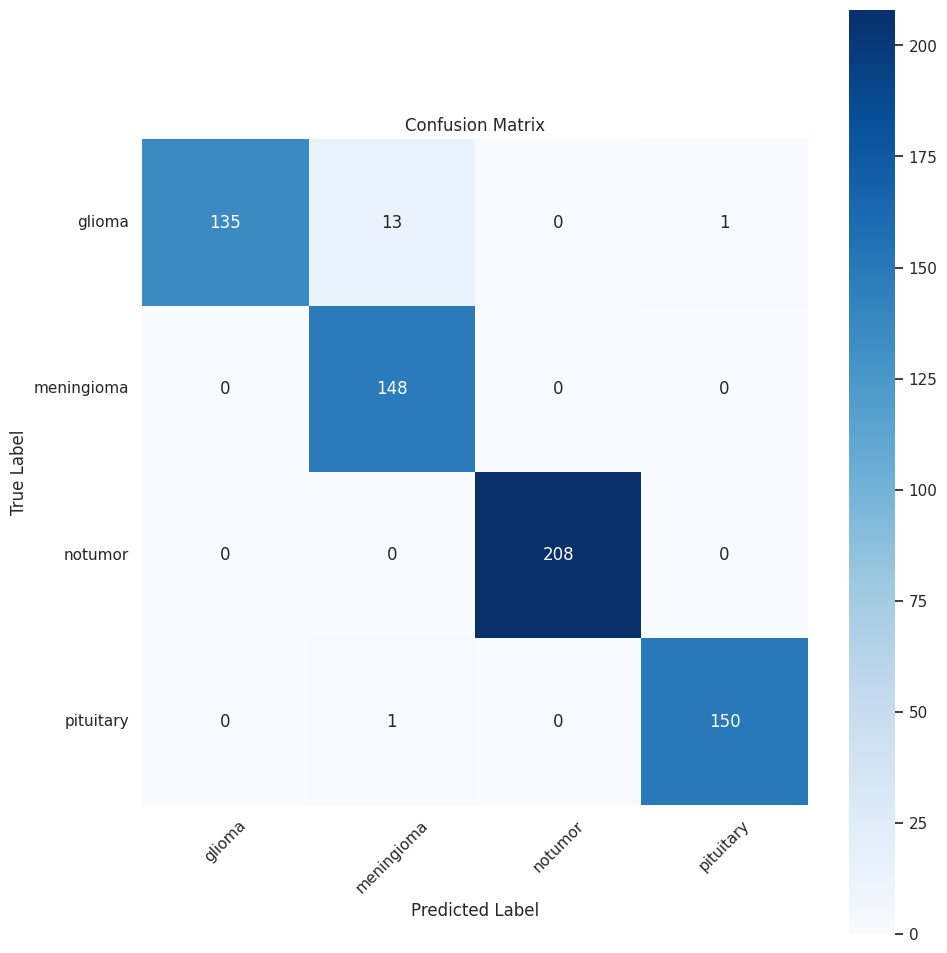

In [24]:
plot_cm(cm_adamax_2, classes)

In [25]:
report_model(test_generator, y_pred_adamax_2, classes)

              precision    recall  f1-score   support

      glioma       1.00      0.91      0.95       149
  meningioma       0.91      1.00      0.95       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.97      0.97       656
weighted avg       0.98      0.98      0.98       656



In [26]:
model_adamax_2.save('classification_brain_tumor_convnextbase_adamax_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.25

In [20]:
model_adamax_3 = model_convnextbase(Adamax,0.0001, 0.25)

In [21]:
history_adamax_3 = history_model(model_adamax_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:00:57 30s/step - accuracy: 0.1875 - loss: 10.7170

I0000 00:00:1721565384.669538     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721565384.726497     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565384.726927     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565384.727451     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6354 - loss: 9.7213

W0000 00:00:1721565437.873451     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565437.873783     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565437.874242     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 174ms/step - accuracy: 0.6358 - loss: 9.7204 - val_accuracy: 0.8656 - val_loss: 8.9660
Epoch 2/30


W0000 00:00:1721565446.707873     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.708337     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.708743     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.710705     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.711084     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.711446     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.711799     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721565446.712160     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8798 - loss: 8.8503 - val_accuracy: 0.9053 - val_loss: 8.5308
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.9240 - loss: 8.3984 - val_accuracy: 0.9282 - val_loss: 8.1055
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9509 - loss: 7.9815 - val_accuracy: 0.9359 - val_loss: 7.6954
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9645 - loss: 7.5653 - val_accuracy: 0.9542 - val_loss: 7.2736
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9717 - loss: 7.1421 - val_accuracy: 0.9573 - val_loss: 6.8502
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9825 - loss: 6.7101 - val_accuracy: 0.9618 - val_loss: 6.4178
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9860 - loss: 6.2866 - val_accuracy: 0.9725 - val_loss: 5.9967
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9897 - loss: 5.8618 - val

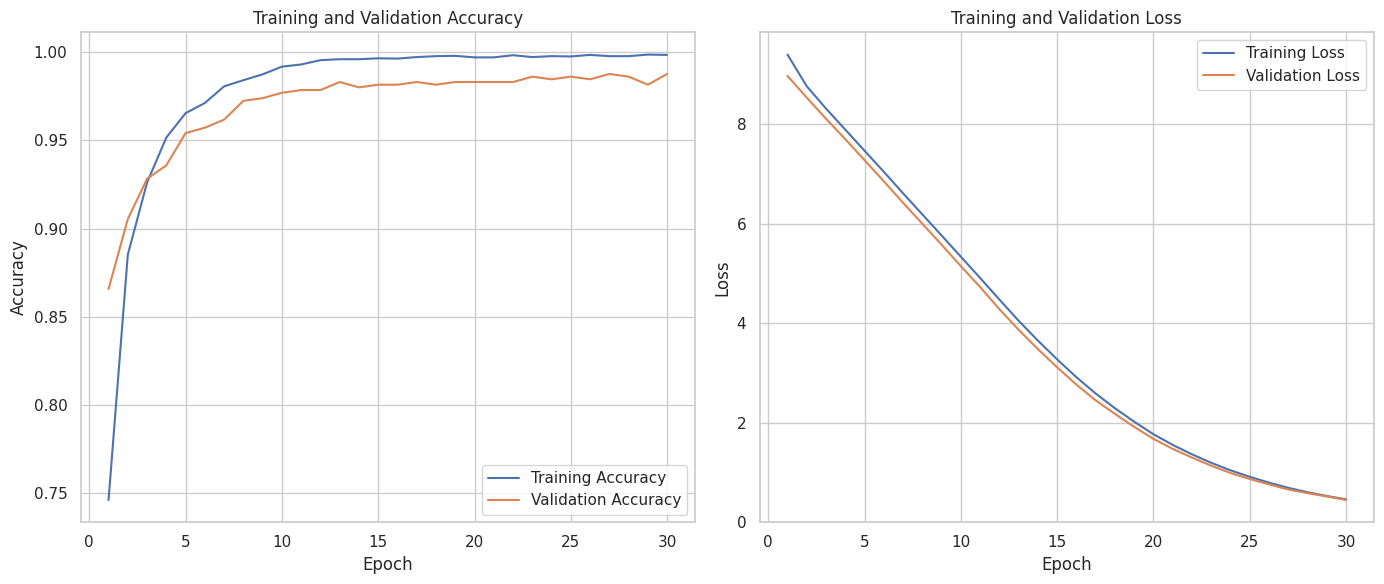

In [22]:
plot_history(history_adamax_3)

In [23]:
evaluate_model(model_adamax_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.9999 - loss: 0.4138
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9902 - loss: 0.4390
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9824 - loss: 0.4661


In [24]:
y_pred_adamax_3, classes, cm_adamax_3 = predict_model(model_adamax_3, test_generator)

 3/41 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step

W0000 00:00:1721567418.217043     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567418.217344     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567418.217772     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


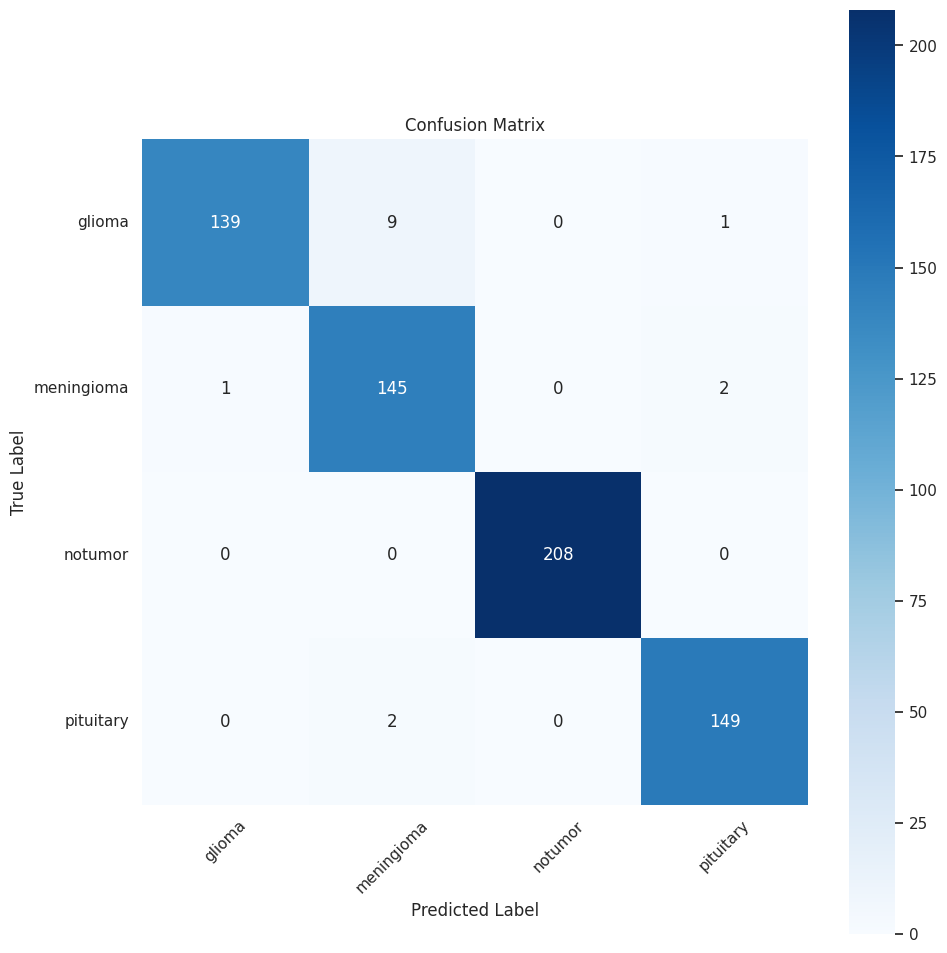

In [25]:
plot_cm(cm_adamax_3, classes)

In [26]:
report_model(test_generator, y_pred_adamax_3, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       149
  meningioma       0.93      0.98      0.95       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.98      0.99      0.98       151

    accuracy                           0.98       656
   macro avg       0.98      0.97      0.97       656
weighted avg       0.98      0.98      0.98       656



In [28]:
model_adamax_3.save('classification_brain_tumor_convnextbase_adamax_3.h5')

### Konfigurasi model 
- learning rate = 0.0001
- dropout = 0.45

In [ ]:
model_adamax_4 = model_convnextbase(Adamax,0.0001, 0.45)

In [21]:
history_adamax_4 = history_model(model_adamax_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:59:19 30s/step - accuracy: 0.3125 - loss: 10.8112

I0000 00:00:1721567661.961498     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721567662.009755     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567662.010103     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567662.010473     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567662.017824     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6104 - loss: 9.8055

W0000 00:00:1721567719.961456     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567719.961857     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567719.962279     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 97s 189ms/step - accuracy: 0.6107 - loss: 9.8046 - val_accuracy: 0.8427 - val_loss: 9.0481
Epoch 2/30


W0000 00:00:1721567729.190954     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.191352     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.191756     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.193782     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.194134     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.194477     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.194861     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721567729.195253     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 51s 142ms/step - accuracy: 0.8404 - loss: 8.9988 - val_accuracy: 0.8931 - val_loss: 8.6754
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.8876 - loss: 8.6344 - val_accuracy: 0.9191 - val_loss: 8.3496
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.9150 - loss: 8.2907 - val_accuracy: 0.9237 - val_loss: 8.0286
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9373 - loss: 7.9528 - val_accuracy: 0.9282 - val_loss: 7.7133
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.9520 - loss: 7.6192 - val_accuracy: 0.9435 - val_loss: 7.3904
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.9640 - loss: 7.2815 - val_accuracy: 0.9573 - val_loss: 7.0640
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.9660 - loss: 6.9596 - val_accuracy: 0.9588 - val_loss: 6.7289
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9792 - loss: 6.6204 - val

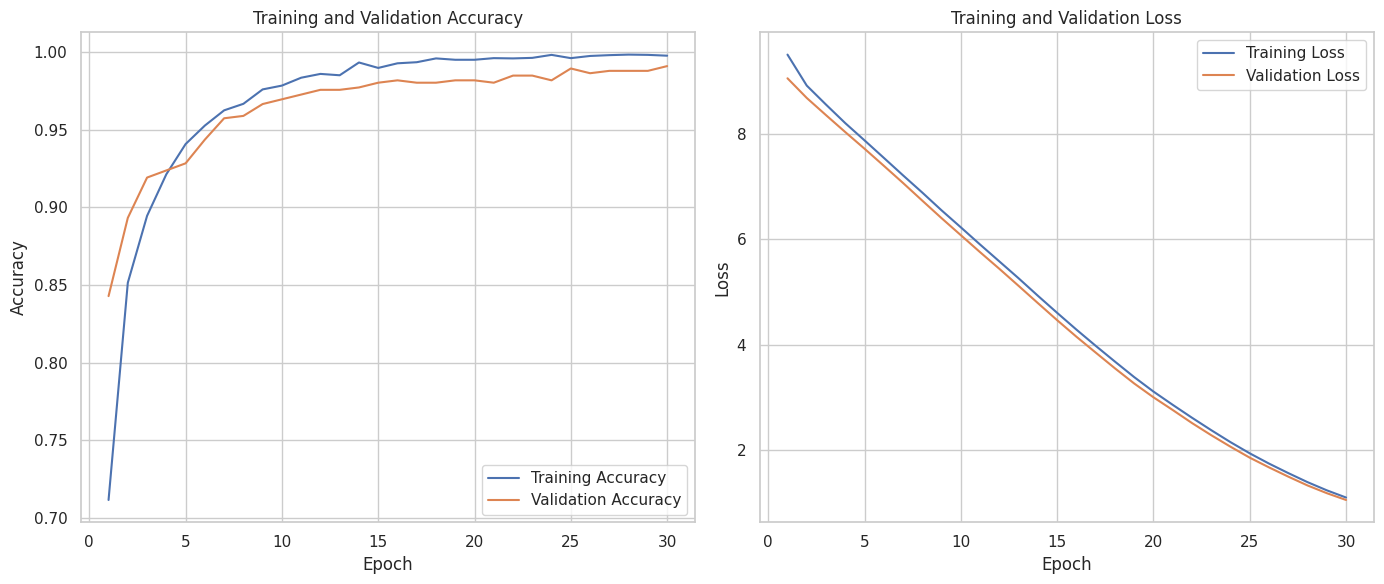

In [22]:
plot_history(history_adamax_4)

In [23]:
evaluate_model(model_adamax_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9999 - loss: 1.0229
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9934 - loss: 1.0514
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9748 - loss: 1.0793


In [24]:
y_pred_adamax_4, classes, cm_adamax_4 = predict_model(model_adamax_4, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

W0000 00:00:1721570865.801998     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721570865.802470     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721570865.802857     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


In [25]:
report_model(test_generator, y_pred_adamax_4, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.91      0.95       149
  meningioma       0.92      0.98      0.95       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.98      0.97      0.97       656



In [26]:
model_adamax_4.save('classification_brain_tumor_convnextbase_adamax_4.h5')

## Optimizer SGD

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.25

In [19]:
from tensorflow.keras.optimizers import SGD

In [19]:
model_SGD_1 = model_convnextbase(SGD,0.001, 0.25)

In [20]:
history_SGD_1 = history_model(model_SGD_1, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:58:19 30s/step - accuracy: 0.1875 - loss: 10.9506

I0000 00:00:1721577427.823287     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721577427.879451     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 92s 175ms/step - accuracy: 0.6993 - loss: 9.5187 - val_accuracy: 0.9069 - val_loss: 8.5387
Epoch 2/30


W0000 00:00:1721577490.053496     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.053813     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.054204     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.056175     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.056482     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.056835     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.057147     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721577490.057457     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9305 - loss: 8.3765 - val_accuracy: 0.9374 - val_loss: 7.9056
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9584 - loss: 7.7514 - val_accuracy: 0.9557 - val_loss: 7.3233
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9715 - loss: 7.1730 - val_accuracy: 0.9573 - val_loss: 6.7966
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9818 - loss: 6.6412 - val_accuracy: 0.9756 - val_loss: 6.2792
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9881 - loss: 6.1305 - val_accuracy: 0.9725 - val_loss: 5.7962
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9877 - loss: 5.6586 - val_accuracy: 0.9802 - val_loss: 5.3287
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9904 - loss: 5.2026 - val_accuracy: 0.9786 - val_loss: 4.8971
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9939 - loss: 4.7675 - val

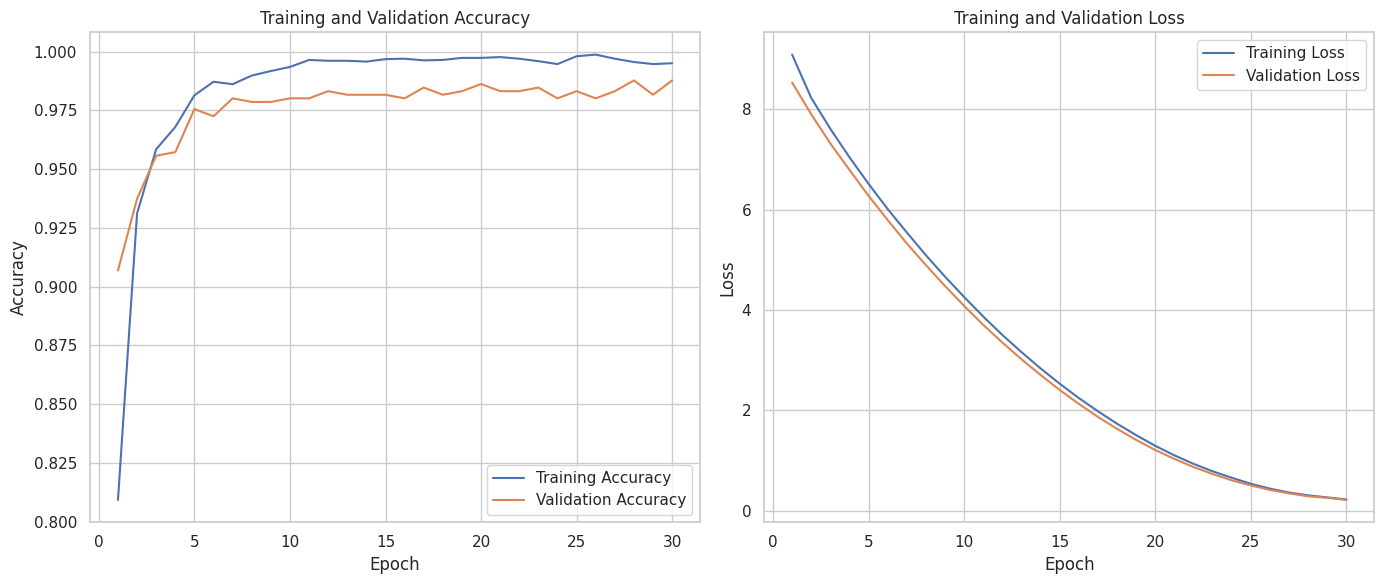

In [21]:
plot_history(history_SGD_1)

In [22]:
evaluate_model(model_SGD_1, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9992 - loss: 0.1827
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9847 - loss: 0.2119
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9843 - loss: 0.2274


In [23]:
y_pred_SGD_1, classes, cm_SGD_1 = predict_model(model_SGD_1, test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step


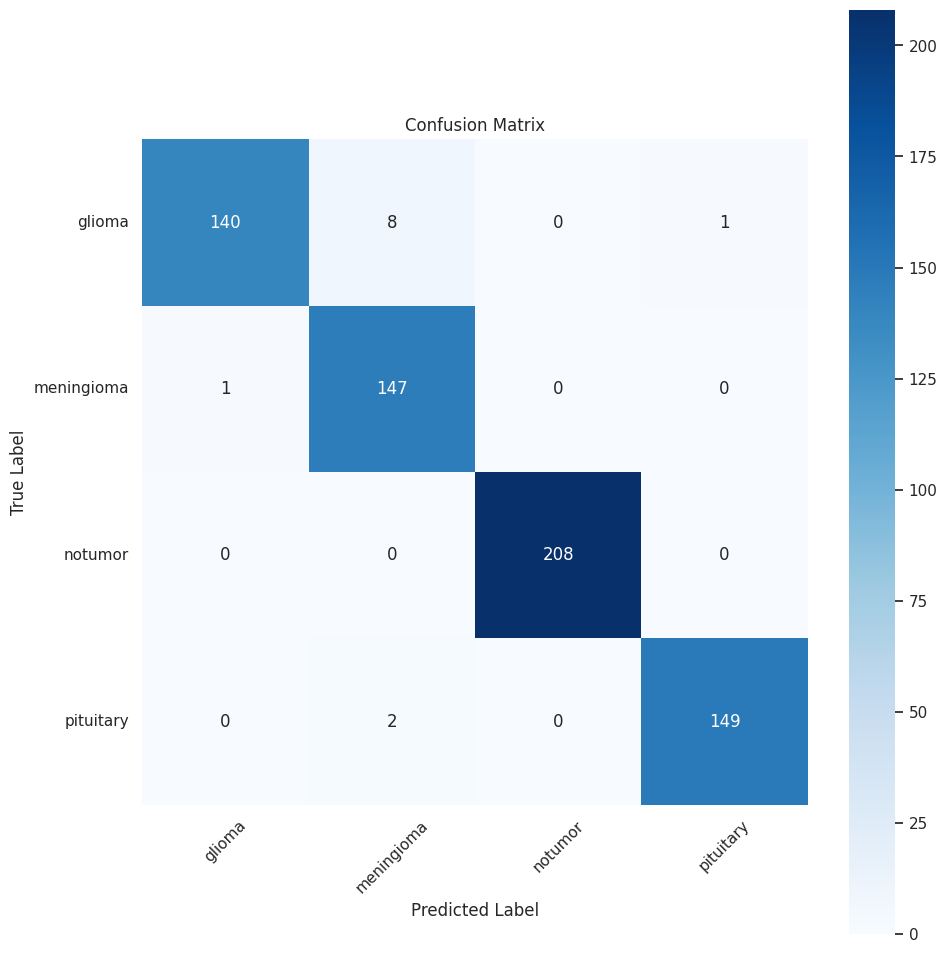

In [24]:
plot_cm(cm_SGD_1, classes)

In [25]:
report_model(test_generator, y_pred_SGD_1, classes)

              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       149
  meningioma       0.94      0.99      0.96       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [27]:
model_SGD_1.save('classification_brain_tumor_convnextbase_SGD_1.h5')

### Konfigurasi model
- learning rate = 0.001
- dropout = 0.45

In [20]:
model_SGD_2 = model_convnextbase(SGD,0.001, 0.45)

In [ ]:
history_SGD_2 = history_model(model_SGD_2, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:57:01 30s/step - accuracy: 0.2500 - loss: 10.8352

I0000 00:00:1721579534.193901     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721579534.242418     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579534.242790     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579534.243190     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579534.250290     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579534.250675     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579534.251245     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6847 - loss: 9.5607

W0000 00:00:1721579581.084364     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579581.084718     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579581.085138     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579581.091728     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579581.092048     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579581.092432     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 86s 157ms/step - accuracy: 0.6850 - loss: 9.5596 - val_accuracy: 0.9008 - val_loss: 8.5621
Epoch 2/30


W0000 00:00:1721579590.011513     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.011902     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.012269     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.014285     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.014661     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.015030     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.015404     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721579590.015780     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9208 - loss: 8.4111 - val_accuracy: 0.9450 - val_loss: 7.9116
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9416 - loss: 7.7893 - val_accuracy: 0.9420 - val_loss: 7.3461
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9588 - loss: 7.2094 - val_accuracy: 0.9618 - val_loss: 6.8065
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9702 - loss: 6.6674 - val_accuracy: 0.9710 - val_loss: 6.2879
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9773 - loss: 6.1527 - val_accuracy: 0.9817 - val_loss: 5.7956
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9784 - loss: 5.6800 - val_accuracy: 0.9802 - val_loss: 5.3342
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9810 - loss: 5.2255 - val_accuracy: 0.9847 - val_loss: 4.8882
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9917 - loss: 4.7748 - val

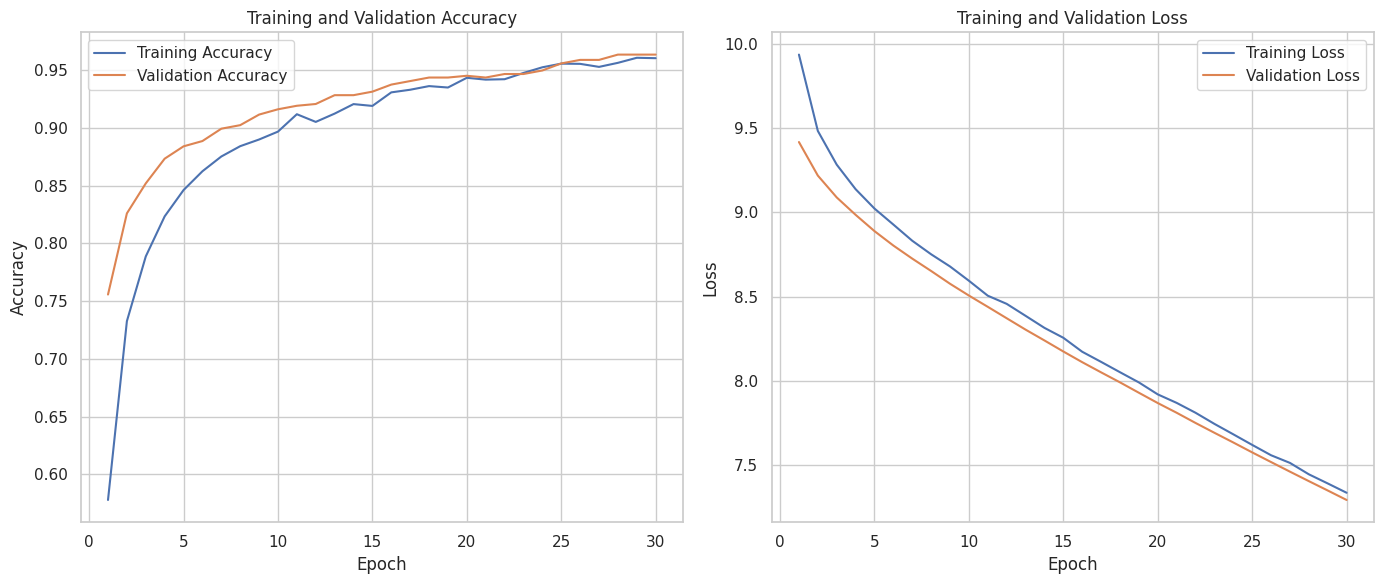

In [20]:
plot_history(history_SGD_2)

In [21]:
evaluate_model(model_SGD_2, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.9901 - loss: 7.2381
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9581 - loss: 7.3018
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9340 - loss: 7.3360


In [22]:
y_pred_SGD_2, classes, cm_SGD_2 = predict_model(model_SGD_2, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step

W0000 00:00:1721576057.554759     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721576057.555222     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721576057.555644     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


In [23]:
report_model(test_generator, y_pred_SGD_2, classes)

              precision    recall  f1-score   support

      glioma       0.96      0.87      0.91       149
  meningioma       0.88      0.91      0.89       148
     notumor       0.96      1.00      0.98       208
   pituitary       0.97      0.97      0.97       151

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [24]:
model_SGD_2.save('classification_brain_tumor_convnextbase_SGD_2.h5')

### Konfigurasi model
- learning rate = 0.0001
- learning rate = 0.25

In [16]:
model_SGD_3 = model_convnextbase(tf.keras.optimizers.SGD,0.0001, 0.25)

In [17]:
history_SGD_3 = history_model(model_SGD_3, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 2:57:26 30s/step - accuracy: 0.3125 - loss: 10.7110

I0000 00:00:1721610927.397276     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721610927.446296     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610927.446676     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610927.447074     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610927.454199     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610927.454628     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610927.455162     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4953 - loss: 10.1286

W0000 00:00:1721610978.956797     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610978.957115     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610978.957592     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610978.964192     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610978.964564     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610978.964973     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 90s 170ms/step - accuracy: 0.4956 - loss: 10.1278 - val_accuracy: 0.7817 - val_loss: 9.4030
Epoch 2/30


W0000 00:00:1721610987.887133     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.887479     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.887879     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.888203     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.888519     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.888847     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.889150     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610987.889460     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.7709 - loss: 9.4154 - val_accuracy: 0.8321 - val_loss: 9.2090
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8204 - loss: 9.2251 - val_accuracy: 0.8565 - val_loss: 9.0859
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8422 - loss: 9.1039 - val_accuracy: 0.8687 - val_loss: 8.9828
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8645 - loss: 8.9945 - val_accuracy: 0.8779 - val_loss: 8.8917
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8736 - loss: 8.9082 - val_accuracy: 0.8916 - val_loss: 8.8077
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8919 - loss: 8.8172 - val_accuracy: 0.8916 - val_loss: 8.7299
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9015 - loss: 8.7337 - val_accuracy: 0.8977 - val_loss: 8.6546
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9016 - loss: 8.6607 - val

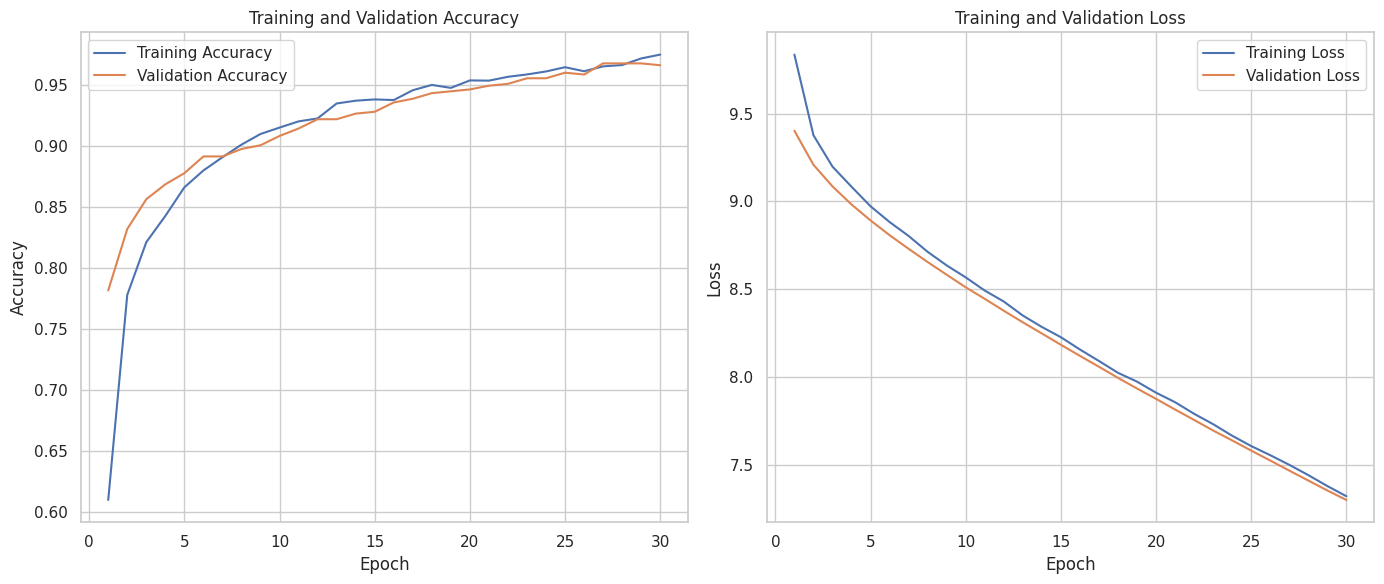

In [18]:
plot_history(history_SGD_3)

In [19]:
evaluate_model(model_SGD_3, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.9927 - loss: 7.2403
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9628 - loss: 7.3029
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9459 - loss: 7.3508


In [20]:
y_pred_SGD_3, classes, cm_SGD_3 = predict_model(model_SGD_3, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step

W0000 00:00:1721612283.982189     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721612283.982596     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721612283.983003     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721612283.989614     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721612283.989942     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721612283.990292     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step


In [21]:
report_model(test_generator, y_pred_SGD_3, classes)

              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       149
  meningioma       0.88      0.95      0.91       148
     notumor       0.99      1.00      0.99       208
   pituitary       0.97      0.97      0.97       151

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [22]:
model_SGD_3.save('classification_brain_tumor_convnextbase_SGD_3.h5')

### Konfigurasi model
- learning rate = 0.0001
- dropout = 0.45

In [16]:
model_SGD_4 = model_convnextbase(tf.keras.optimizers.SGD,0.0001, 0.45)

In [17]:
history_SGD_4 = history_model(model_SGD_4, train_generator, 30, 1, valid_generator, False)

Epoch 1/30
  1/357 ━━━━━━━━━━━━━━━━━━━━ 3:01:08 31s/step - accuracy: 0.2500 - loss: 11.1844

I0000 00:00:1721609093.825324     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721609093.879393     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609093.879925     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609093.880431     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609093.888663     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4180 - loss: 10.3768

W0000 00:00:1721609145.533160     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609145.533688     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609145.534159     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 91s 171ms/step - accuracy: 0.4183 - loss: 10.3758 - val_accuracy: 0.7695 - val_loss: 9.4209
Epoch 2/30


W0000 00:00:1721609154.825260     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609154.825607     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609154.826020     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609154.833057     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609154.833457     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721609154.833978     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.7217 - loss: 9.5361 - val_accuracy: 0.8275 - val_loss: 9.2250
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.7874 - loss: 9.3083 - val_accuracy: 0.8473 - val_loss: 9.0992
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8241 - loss: 9.1422 - val_accuracy: 0.8702 - val_loss: 8.9975
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8330 - loss: 9.0541 - val_accuracy: 0.8824 - val_loss: 8.9055
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8620 - loss: 8.9319 - val_accuracy: 0.8840 - val_loss: 8.8222
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8614 - loss: 8.8692 - val_accuracy: 0.8931 - val_loss: 8.7408
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8837 - loss: 8.7690 - val_accuracy: 0.8947 - val_loss: 8.6705
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8946 - loss: 8.6842 - val

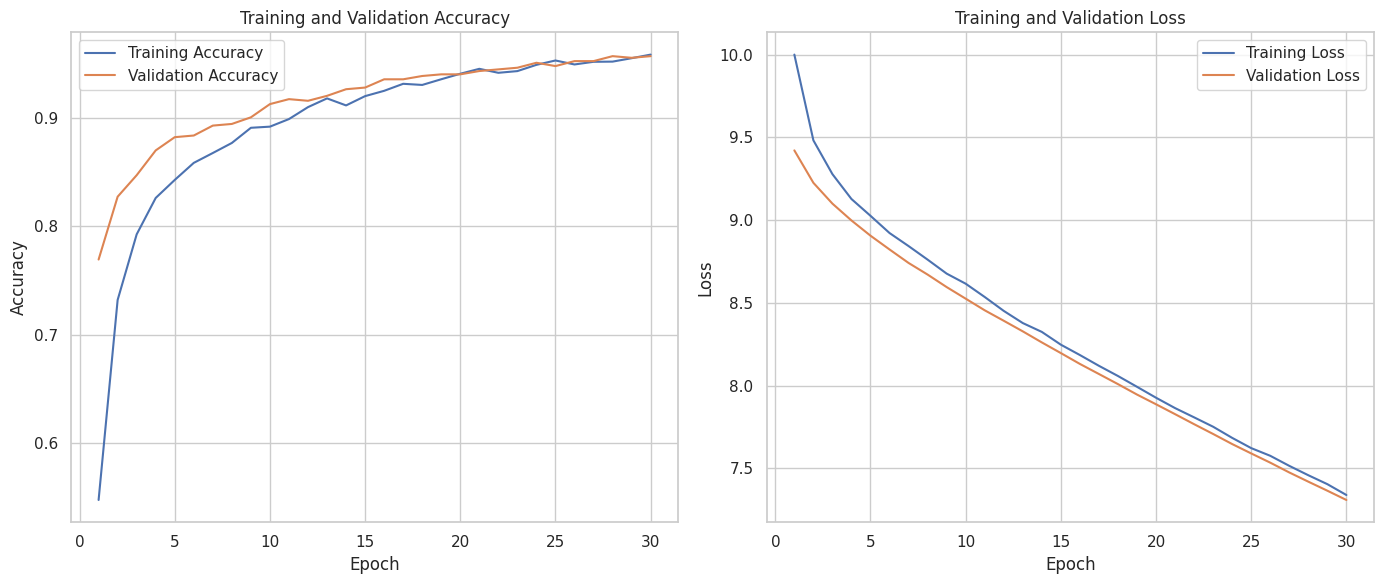

In [18]:
plot_history(history_SGD_4)

In [19]:
evaluate_model(model_SGD_4, train_generator, valid_generator,
               test_generator, 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9895 - loss: 7.2405
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9578 - loss: 7.3056
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9504 - loss: 7.3296


In [20]:
y_pred_SGD_4, classes, cm_SGD_4 = predict_model(model_SGD_4, test_generator)

 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step

W0000 00:00:1721610596.950961     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610596.951309     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721610596.951746     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step


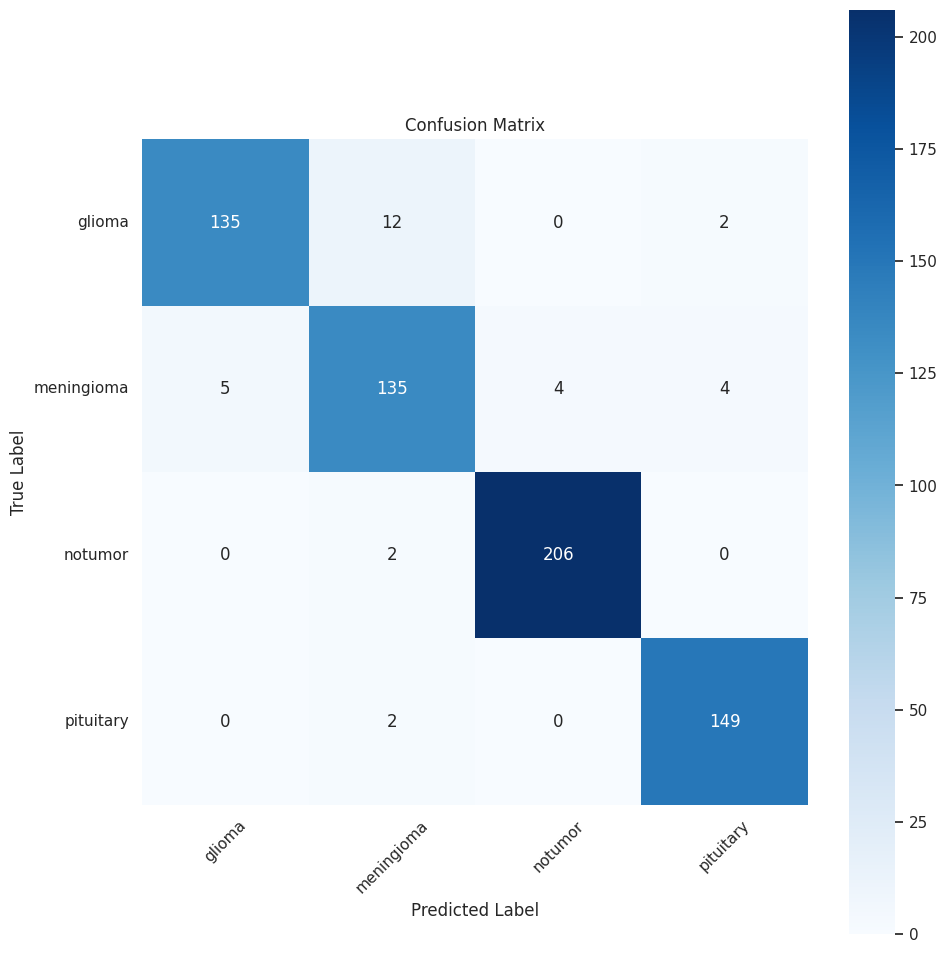

In [22]:
plot_cm(cm_SGD_4, classes)

In [23]:
report_model(test_generator, y_pred_SGD_4, classes)

              precision    recall  f1-score   support

      glioma       0.96      0.91      0.93       149
  meningioma       0.89      0.91      0.90       148
     notumor       0.98      0.99      0.99       208
   pituitary       0.96      0.99      0.97       151

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [24]:
model_SGD_4.save('classification_brain_tumor_convnextbase_SGD_4.h5')